In [1]:
import os
import sys

import random 
import numpy as np
import matplotlib.pyplot as plt

import scanpy as sc
import scvi
import scgen

import torch
from lightning.pytorch.loggers import CSVLogger

import pandas as pd

import session_info
import warnings
from pyprojroot.here import here

torch.set_float32_matmul_precision('medium')

random_seed = 42

scvi.settings.dl_num_workers = 8
scvi.settings.seed = random_seed
print("scvi-tools version:", scvi.__version__)

Seed set to 42


scvi-tools version: 1.1.2


### Parameters

In [2]:
n_latent = 30
batch_key = 'chemistry'
annotation = 'Level1'

## Loading main adata

In [3]:
adataM = sc.read_h5ad(here("03_downstream_analysis/02_gene_universe_definition/results/04_MAIN_geneUniverse_noRBCnPlatelets.log1p.h5ad"))
adataM

AnnData object with n_obs × n_vars = 4279352 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'highly_variable'
    uns: 'log1p'

### scGen preprocessing

In [4]:
adataM.obs['batch'] = adataM.obs[batch_key].tolist()
adataM.obs['cell_type'] = adataM.obs[annotation].tolist()
scgen.SCGEN.setup_anndata(adataM, batch_key="batch", labels_key="cell_type")

#### scGen parameters

In [5]:
scgen_model_params = dict({
    'n_latent': n_latent,
    'n_hidden': 800,
    'n_layers': 3,
    'dropout_rate': 0.2,
})

In [6]:
train_params = dict({
    'max_epochs':1000,
    'batch_size':128, 
    'early_stopping': True, 
    'early_stopping_patience':5, 
    'log_every_n_steps':10000,
    #'plan_kwargs':dict({'lr':0.001}) # default learning rate
})

In [7]:
model_scGen = scgen.SCGEN(adataM, **scgen_model_params)
model_scGen.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `SCGEN.setup_anndata` with arguments:

{'batch_key': 'batch', 'labels_key': 'cell_type'}

      Summary Statistics      
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Summary Stat Key ┃  Value  ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│     n_batch      │    4    │
│     n_cells      │ 4279352 │
│     n_labels     │   13    │
│      n_vars      │  8253   │
└──────────────────┴─────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │  3_GEX_V2  │          0          │
│                    │  3_GEX_V3  │          1          │
│                    │  5_GEX_V1  │          2          │
│                    │  5_GEX_V2  │          3          │
└────────────────────┴────────────┴─────────────────────┘

                      labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │       B        │          0          │
│                        │ Cycling_cells  │          1          │
│                        │       DC       │          2          │
│                        │      ILC       │          3          │
│                        │      Mono      │          4          │
│                        │     Plasma     │          5          │
│                        │  Progenitors   │          6          │
│                        │  T_CD4_Naive   │          7          │
│                        │ T_CD4_NonNaive │          8          │
│                        │  T_CD8_Naive   │          9          │
│                        │ T_CD8_NonNaive │         10          │
│                        │      UTC       │         11          │
│                        │      pDC       │         12          │
└────────────────────────┴────────────────┴─────────────────────┘

### Training the model

In [8]:
model_scGen.train(**train_params)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|                                                                                                                       | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000:   0%|                                                                                                                   | 0/1000 [00:00<?, ?it/s]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/1000:   0%|                                                                                                      | 1/1000 [08:02<133:57:30, 482.73s/it]

Epoch 1/1000:   0%|                                          | 1/1000 [08:02<133:57:30, 482.73s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.19e+3]

Epoch 2/1000:   0%|                                          | 1/1000 [08:02<133:57:30, 482.73s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.19e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/1000:   0%|                                          | 2/1000 [16:13<135:07:49, 487.44s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.19e+3]

Epoch 2/1000:   0%|                                          | 2/1000 [16:13<135:07:49, 487.44s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.17e+3]

Epoch 3/1000:   0%|                                          | 2/1000 [16:13<135:07:49, 487.44s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.17e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/1000:   0%|▏                                         | 3/1000 [24:26<135:43:06, 490.06s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.17e+3]

Epoch 3/1000:   0%|▏                                         | 3/1000 [24:26<135:43:06, 490.06s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.17e+3]

Epoch 4/1000:   0%|▏                                         | 3/1000 [24:26<135:43:06, 490.06s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.17e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/1000:   0%|▏                                         | 4/1000 [32:37<135:40:32, 490.39s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.17e+3]

Epoch 4/1000:   0%|▏                                         | 4/1000 [32:37<135:40:32, 490.39s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.16e+3]

Epoch 5/1000:   0%|▏                                         | 4/1000 [32:37<135:40:32, 490.39s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/1000:   0%|▏                                         | 5/1000 [40:48<135:32:51, 490.42s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.16e+3]

Epoch 5/1000:   0%|▏                                         | 5/1000 [40:48<135:32:51, 490.42s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.16e+3]

Epoch 6/1000:   0%|▏                                         | 5/1000 [40:48<135:32:51, 490.42s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/1000:   1%|▎                                         | 6/1000 [48:58<135:23:48, 490.37s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.16e+3]

Epoch 6/1000:   1%|▎                                         | 6/1000 [48:58<135:23:48, 490.37s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.16e+3]

Epoch 7/1000:   1%|▎                                         | 6/1000 [48:58<135:23:48, 490.37s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/1000:   1%|▎                                         | 7/1000 [57:07<135:10:10, 490.04s/it, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=1.16e+3]

Epoch 7/1000:   1%|▎                                         | 7/1000 [57:07<135:10:10, 490.04s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=1.16e+3]

Epoch 8/1000:   1%|▎                                         | 7/1000 [57:07<135:10:10, 490.04s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/1000:   1%|▎                                       | 8/1000 [1:05:21<135:21:20, 491.21s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=1.16e+3]

Epoch 8/1000:   1%|▎                                       | 8/1000 [1:05:21<135:21:20, 491.21s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.16e+3]

Epoch 9/1000:   1%|▎                                       | 8/1000 [1:05:21<135:21:20, 491.21s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/1000:   1%|▎                                       | 9/1000 [1:13:33<135:17:09, 491.45s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.16e+3]

Epoch 9/1000:   1%|▎                                       | 9/1000 [1:13:33<135:17:09, 491.45s/it, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.16e+3]

Epoch 10/1000:   1%|▎                                      | 9/1000 [1:13:33<135:17:09, 491.45s/it, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/1000:   1%|▍                                     | 10/1000 [1:21:48<135:28:09, 492.62s/it, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.16e+3]

Epoch 10/1000:   1%|▍                                     | 10/1000 [1:21:48<135:28:09, 492.62s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.16e+3]

Epoch 11/1000:   1%|▍                                     | 10/1000 [1:21:48<135:28:09, 492.62s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/1000:   1%|▍                                     | 11/1000 [1:29:56<134:54:04, 491.05s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.16e+3]

Epoch 11/1000:   1%|▍                                     | 11/1000 [1:29:56<134:54:04, 491.05s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.16e+3]

Epoch 12/1000:   1%|▍                                     | 11/1000 [1:29:56<134:54:04, 491.05s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/1000:   1%|▍                                     | 12/1000 [1:38:07<134:45:33, 491.03s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.16e+3]

Epoch 12/1000:   1%|▍                                     | 12/1000 [1:38:07<134:45:33, 491.03s/it, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.16e+3]

Epoch 13/1000:   1%|▍                                     | 12/1000 [1:38:07<134:45:33, 491.03s/it, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/1000:   1%|▍                                     | 13/1000 [1:46:17<134:36:13, 490.96s/it, v_num=1, train_loss_step=1.24e+3, train_loss_epoch=1.16e+3]

Epoch 13/1000:   1%|▍                                     | 13/1000 [1:46:17<134:36:13, 490.96s/it, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.16e+3]

Epoch 14/1000:   1%|▍                                     | 13/1000 [1:46:17<134:36:13, 490.96s/it, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/1000:   1%|▌                                     | 14/1000 [1:54:28<134:27:15, 490.91s/it, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.16e+3]

Epoch 14/1000:   1%|▌                                     | 14/1000 [1:54:28<134:27:15, 490.91s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.16e+3]

Epoch 15/1000:   1%|▌                                     | 14/1000 [1:54:28<134:27:15, 490.91s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/1000:   2%|▌                                     | 15/1000 [2:02:44<134:44:44, 492.47s/it, v_num=1, train_loss_step=1.22e+3, train_loss_epoch=1.16e+3]

Epoch 15/1000:   2%|▌                                     | 15/1000 [2:02:44<134:44:44, 492.47s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.16e+3]

Epoch 16/1000:   2%|▌                                     | 15/1000 [2:02:44<134:44:44, 492.47s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 16/1000:   2%|▌                                     | 16/1000 [2:11:00<134:50:41, 493.34s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.16e+3]

Epoch 16/1000:   2%|▌                                     | 16/1000 [2:11:00<134:50:41, 493.34s/it, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.16e+3]

Epoch 17/1000:   2%|▌                                     | 16/1000 [2:11:00<134:50:41, 493.34s/it, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.16e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 17/1000:   2%|▋                                     | 17/1000 [2:19:11<134:34:34, 492.85s/it, v_num=1, train_loss_step=1.29e+3, train_loss_epoch=1.16e+3]

Epoch 17/1000:   2%|▋                                     | 17/1000 [2:19:11<134:34:34, 492.85s/it, v_num=1, train_loss_step=1.64e+3, train_loss_epoch=1.15e+3]

Epoch 18/1000:   2%|▋                                     | 17/1000 [2:19:11<134:34:34, 492.85s/it, v_num=1, train_loss_step=1.64e+3, train_loss_epoch=1.15e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18/1000:   2%|▋                                     | 18/1000 [2:27:24<134:23:20, 492.67s/it, v_num=1, train_loss_step=1.64e+3, train_loss_epoch=1.15e+3]

Epoch 18/1000:   2%|▋                                     | 18/1000 [2:27:24<134:23:20, 492.67s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.15e+3]

Epoch 19/1000:   2%|▋                                     | 18/1000 [2:27:24<134:23:20, 492.67s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.15e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 19/1000:   2%|▋                                     | 19/1000 [2:35:38<134:22:39, 493.13s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.15e+3]

Epoch 19/1000:   2%|▋                                     | 19/1000 [2:35:38<134:22:39, 493.13s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.15e+3]

Epoch 20/1000:   2%|▋                                     | 19/1000 [2:35:38<134:22:39, 493.13s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.15e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 20/1000:   2%|▊                                     | 20/1000 [2:43:49<134:06:48, 492.66s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.15e+3]

Epoch 20/1000:   2%|▊                                     | 20/1000 [2:43:49<134:06:48, 492.66s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.15e+3]

Epoch 21/1000:   2%|▊                                     | 20/1000 [2:43:49<134:06:48, 492.66s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.15e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 21/1000:   2%|▊                                     | 21/1000 [2:52:01<133:54:10, 492.39s/it, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.15e+3]

Epoch 21/1000:   2%|▊                                     | 21/1000 [2:52:01<133:54:10, 492.39s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.15e+3]

Epoch 21/1000:   2%|▊                                     | 21/1000 [2:52:01<133:39:42, 491.50s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.15e+3]

/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/scratch_isilon/groups/singlecell/shared/conda_env/scvi-v112/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Monitored metric elbo_validation did not improve in the last 5 records. Best score: 3096.466. Signaling Trainer to stop.


### Plotting loss functions

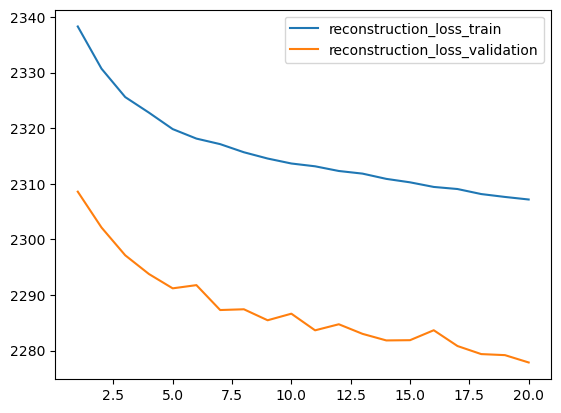

In [9]:
plt.plot(model_scGen.history['reconstruction_loss_train'][1:], label = 'reconstruction_loss_train')
plt.plot(model_scGen.history['reconstruction_loss_validation'][1:], label = 'reconstruction_loss_validation')
plt.title('')
plt.legend()
plt.show()

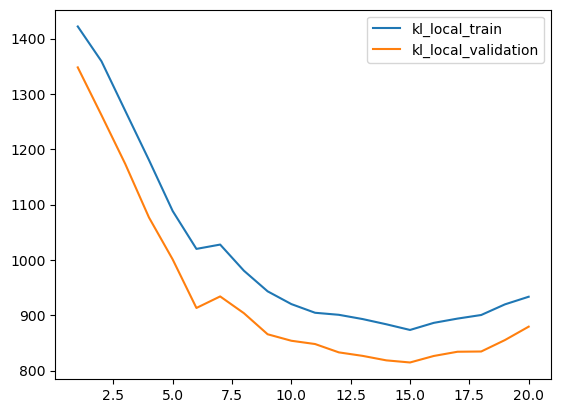

In [10]:
plt.plot(model_scGen.history['kl_local_train'][1:], label = 'kl_local_train')
plt.plot(model_scGen.history['kl_local_validation'][1:], label = 'kl_local_validation')
plt.title('')
plt.legend()
plt.show()

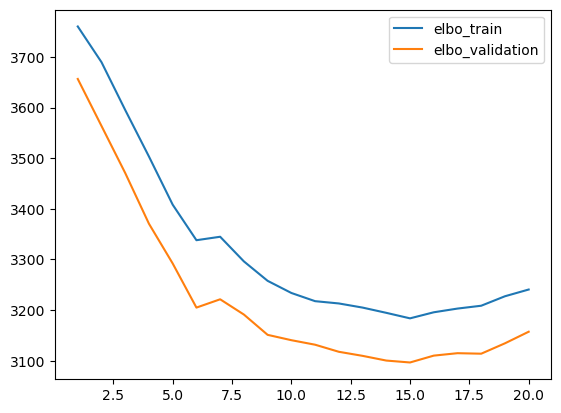

In [11]:
plt.plot(model_scGen.history['elbo_train'][1:], label = 'elbo_train')
plt.plot(model_scGen.history['elbo_validation'][1:], label = 'elbo_validation')
plt.title('')
plt.legend()
plt.show()

### Save the results

**scGen model**

In [12]:
model_scGen.save(here('03_downstream_analysis/04_integration_with_annotation/results/scGen_model_noRBCnPlat'), overwrite = True, save_anndata = False)